In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import open3d as o3d
import open3d.visualization as o3d_vis
import copy

In [20]:
%load_ext autoreload
%autoreload 2
import sfm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading Images

In [23]:
images = glob.glob('./data/*.JPG')
rgbs = []
grays = []
images = sorted(images)
length = len(rgbs)-1

# read images
for i in range(len(images)):
    rgb = cv2.imread(images[i])
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    rgbs.append(rgb)
    # print(rgb.shape)
    # plt.imshow(rgb)
    # plt.axis('off')
    # plt.show()

w, h, ch = rgbs[0].shape
print(w,h,ch)

4032 3024 3


In [25]:
# Inrinsic Parameter and Distortion found on calibration.ipynb
K = np.array([[3.11673899e+03, 0.00000000e+00, 1.46846666e+03],
           [0.00000000e+00, 3.09463761e+03, 2.00977621e+03],
           [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], dtype=np.float64)
dist = np.array([[0.21993938, -1.25276135, -0.00397022, -0.00614107, 2.70973121]], dtype=np.float64)


# Correspondence Search

## Feature Extraction

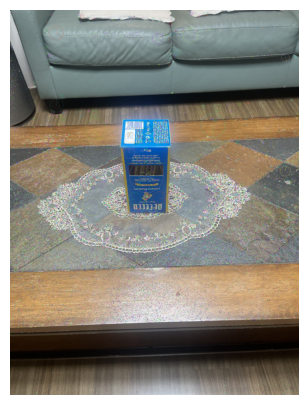

In [29]:
kps, dess, imgs_with_kps = sfm.feature_extraction(rgbs)

plt.figure(figsize=(10,5))
plt.imshow(imgs_with_kps[0])
plt.axis('off')
plt.show()


## Feature Matching


image0 and image1 have 12983 matching points


image1 and image2 have 16531 matching points


image2 and image3 have 16279 matching points


image3 and image4 have 18301 matching points


image4 and image5 have 16867 matching points


image5 and image6 have 16434 matching points


image6 and image7 have 25642 matching points


image7 and image8 have 24897 matching points


image8 and image9 have 22629 matching points



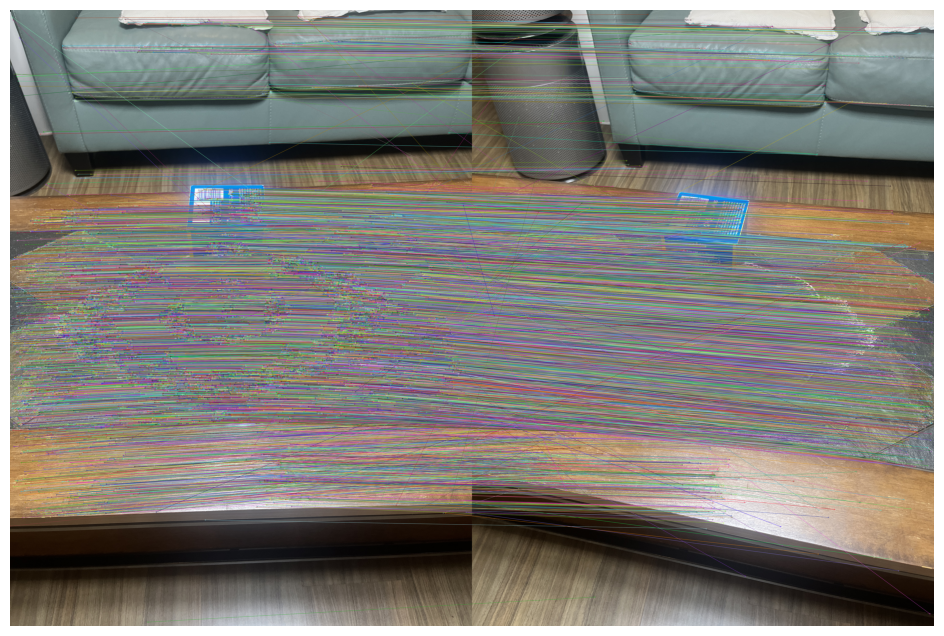

In [39]:
good_matches, matching_points, matches_count = sfm.feature_matching_FLANN(rgbs,kps,dess)


img = cv2.drawMatchesKnn(rgbs[0],kps[0],rgbs[1],kps[1],good_matches[0],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [49]:
print(matches_count)
length = len(matching_points)
print(length)

[12983, 16531, 16279, 18301, 16867, 16434, 25642, 24897, 22629]
9


## Geometric Verification

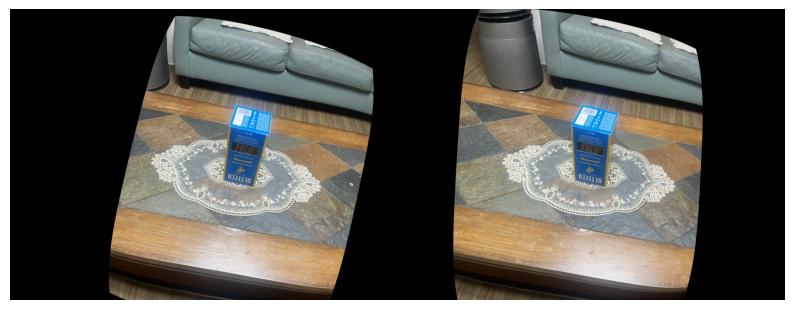

In [52]:
rectified_images = []
for i in range(length):
    R_, T_ = sfm.find_Rotation_and_translation(matching_points[0], K, dist)
    img1_rect, img2_rect = sfm.geometric_verification(rgbs[i],rgbs[i+1], R_, T_, K, dist, w, h)
    rectified_images.append(np.hstack((img1_rect, img2_rect)))

plt.figure(figsize=(10,8))
plt.imshow(rectified_images[0])
plt.axis('off')
plt.show()


# Incremental Reconstruction

In [54]:
cameras, points_3d, colors, most_match, matching_points_ = sfm.initialize_reconstruction(matching_points, K, dist, rgbs, matches_count)
filtered_matching_points = copy.deepcopy(matching_points)
filtered_matching_points[most_match] = matching_points_

In [56]:
# Register images alternating between right and left

left_idx = most_match - 1
right_idx = most_match + 2

count = 0

while left_idx >= 0 or right_idx < len(rgbs):
    count += 1
    if right_idx < len(rgbs):
        print(f"Adding right image {right_idx}")
        cameras, points_3d, colors, new_matching_points = sfm.register_new_image_right(
            points_3d, filtered_matching_points, rgbs, colors, right_idx, K, cameras
        )
        filtered_matching_points[right_idx-1] = new_matching_points
        right_idx += 1
        
        
    if left_idx >= 0:
        print(f"Adding left image {left_idx}")
        cameras, points_3d, colors, new_matching_points = sfm.register_new_image_left(
            points_3d, filtered_matching_points, rgbs, colors, left_idx, K, cameras
        )
        filtered_matching_points[left_idx] = new_matching_points
        left_idx -= 1


Adding right image 2
Number of points being added from image2: 8314
Adding right image 3
Number of points being added from image3: 5280
Adding right image 4
Number of points being added from image4: 6146
Adding right image 5
Number of points being added from image5: 4902
Adding right image 6
Number of points being added from image6: 4960
Adding right image 7
Number of points being added from image7: 9726
Adding right image 8
Number of points being added from image8: 7760
Adding right image 9
Number of points being added from image9: 6503


In [58]:
print(len(points_3d))
print(len(colors))

61413
61413


In [60]:
# before removing outliers
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)
pcd.colors = o3d.utility.Vector3dVector(colors)
# o3d.visualization.draw([pcd])

In [62]:
# final outliers removal
_, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2)
inlier_pcd = pcd.select_by_index(ind)

o3d.visualization.draw([inlier_pcd])

2025-01-08 14:26:37.053 python[22079:16799279] +[IMKClient subclass]: chose IMKClient_Legacy
2025-01-08 14:26:37.053 python[22079:16799279] +[IMKInputSession subclass]: chose IMKInputSession_Legacy
[error] GLFW error: Cocoa: Failed to find service port for display


FEngine (64 bits) created at 0x3eff44000 (threading is enabled)
FEngine resolved backend: OpenGL


In [64]:
# o3d.io.write_point_cloud('final_result.ply', inlier_pcd)

True